# Federated learning: Simple experiment using TensorFlow learning model

In this notebook we provide a simple example of how to make an experiment of a federated environment with the help of this framework. We are going to use a popular dataset to start the experimentation in a federated environment. The framework provides some functions to load the [Emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset) Digits dataset.

In [1]:
import shfl

database = shfl.data_base.Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()

Using TensorFlow backend.


Let's inspect some properties of the loaded data.

In [2]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data[0]))
train_data[0].shape

200000
40000
40000
<class 'numpy.ndarray'>


(28, 28)

So, as we have seen, our dataset is composed by a set of matrixes of 28 by 28. Before starting with the federated scenario, we can take a look to a sample in the training data.

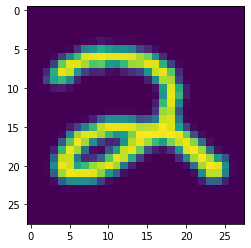

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])

We are going to simulate a federated learning scenario with a set of client nodes containing private data, and a central server that will be responsible to coordinate the different clients. But, first of all, we have to simulate the data contained in every client. In order to do that, we are going to use the previous dataset loaded. The assumption in this example will be the data is distributed as a set of independent and identically distributed random variables, having every node more o less the same amount of data. There are a set of different posibilities in order to distribute the data. The distribution of the data is one of the factors that could impact more to a federated algorithm. Therefore, the framework contains the implementation of some of the most common distributions that allow you to experiment different situations easily. In [Federated Sampling](./federated_sampling.ipynb) you can dig into the options that the framework provides at the moment.

In [4]:
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=20, percent=10)

That's it! We have created federated data from the Emnist dataset using 20 nodes and 10 percent of the available data. This data is distributed to a set of data nodes in the form of private data. Let's learn a little moer about the federated data.

In [5]:
print(type(federated_data))
print(federated_data.num_nodes())
federated_data[0].private_data

<class 'shfl.private.federated_operation.FederatedData'>
20
Node private data, you can see the data for debug purposes but the data remains in the node
<class 'dict'>
{'140593289989088': <shfl.private.data.LabeledData object at 0x7fde6d1b07f0>}


As we can see, private data in a node is not accesible directly but the framework provides mechanisms to use this data in a machine learning model. A federated learning algorithm is defined by a machine learning model locally deployed in each node that learns from the respective node’s private data and an aggregating mechanism to aggregate the different model parameters uploaded by the client nodes to a central node. In this example we will use a deep learning model using keras to build it. The framework provides classes to allow using Tensorflow and Keras (see [Basic Concepts](./basic_concepts.ipynb)) model into a federated learning scenario, your job is only to create a function acting as model builder. Moreover, the framework provides classes to allow using pretrained Tensorflow and Keras models (see [Basic Concepts Pretrained Models](./basic_concepts_pretrained_model.ipynb)). In this example build a Tensorflow learning model.  

In [6]:
import tensorflow as tf
#If you want execute in GPU, you must uncomment this two lines.
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

class CustomDense(tf.keras.layers.Layer):
    """
    Implementation of Linear layer

    Attributes
    ----------
    units : int
        number of units for the output
    w : matrix
        Weights from the layer
    b : array
        Bias from the layer
    """

    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self._units = units

    def build(self, input_shape):
        """
        Method for build the params

        Parameters
        ----------
        input_shape: list
            size of inputs
        """
        self._w = self.add_weight(shape=(input_shape[-1], self._units),
                                  initializer='random_normal',
                                  trainable=True)

        self._b = self.add_weight(shape=(self._units,),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        """
        Apply linear layer

        Parameters
        ----------
        inputs: matrix
            Input data

        Return
        ------
        result : matrix
            the result of linear transformation of the data
        """
        return tf.nn.bias_add(tf.matmul(inputs, self._w), self._b)


def model_builder():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = CustomDense(128)(x)
    x = tf.nn.relu(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = CustomDense(64)(x)
    x = tf.nn.relu(x)
    x = CustomDense(10)(x)
    outputs = tf.nn.softmax(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return shfl.model.DeepLearningModel(model)

Now, the only piece missing is the aggregation operator. Nevertheless, the framework provides some aggregation operators that we can use. In the following piece of code we define the federated aggregation mechanism. Moreover, we define de federated goverment based on the keras learning model, the federated data and the aggregation mechanism.

In [7]:
aggregator = shfl.federated_aggregator.AvgFedAggregator()
federated_government = shfl.learning_approach.FederatedGovernment(model_builder, federated_data, aggregator)

If you want to see all the aggregation operators you can follow the following notebook [Federated Aggregation Operators](./basic_concepts_aggregation_operators.ipynb). Before running the algorithm, we want to apply a transformation to the data. The good practise to do that is to define a federated operation that will ensure that the transformation is applied to the federated data in all the client nodes. We want to reshape the data, so we define the following FederatedTransformation.

In [8]:
import numpy as np

class Reshape(shfl.private.FederatedTransformation):
    
    def apply(self, labeled_data):
        labeled_data.data = np.reshape(labeled_data.data, (labeled_data.data.shape[0], labeled_data.data.shape[1], labeled_data.data.shape[2],1))

class CastFloat(shfl.private.FederatedTransformation):
    
    def apply(self, labeled_data):
        labeled_data.data = labeled_data.data.astype(np.float32)
        
shfl.private.federated_operation.apply_federated_transformation(federated_data, Reshape())
shfl.private.federated_operation.apply_federated_transformation(federated_data, CastFloat())

We are now ready to execute our federated learning algorithm.

In [9]:
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2],1))
test_data = test_data.astype(np.float32)
federated_government.run_rounds(3, test_data, test_label)

Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b8a58>: [1.1984880539894105, 0.640975]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b86d8>: [1.2693754826545716, 0.628575]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b0a58>: [1.1828730251312256, 0.63765]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b0828>: [1.1343182158470153, 0.67545]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b0668>: [1.3747762780189514, 0.520425]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b0cc0>: [1.052249338722229, 0.713375]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fde6d1b0a90>: [1.1979580706596376, 0.652575]
Test performance client <shfl.private.federated_